# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow import keras
print(tf.__version__)
print(tf.executing_eagerly())

2.6.0
True


In [2]:
 import tensorflow_hub as hub

In [3]:
base_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", output_shape=[1001])
])
base_model.build([None, 224, 224, 3]) 

In [4]:
base_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [5]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


## Функции загрузки данных

In [6]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('D:/Users/Doom/Downloads/dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files = glob('D:/Users/Doom/Downloads/dogs-vs-cats-redux-kernels-edition/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

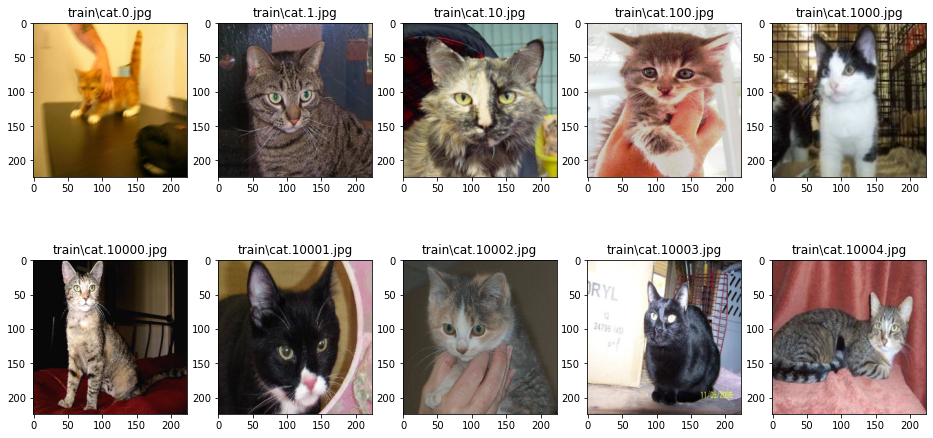

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [8]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


## Добавляем полносвязный слой

In [9]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output



x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [10]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_input (InputLaye [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1002      
Total params: 3,541,267
Trainable params: 1,002
Non-trainable params: 3,540,265
_________________________________________________________________


## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=20,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

In [ ]:
model.save('cats-dogs-vgg16.hdf5')


In [ ]:
model.load('cats-dogs-vgg16.hdf5')

In [ ]:
### Unfreeze the base model
base_model.trainable = True
###
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .000000005),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
model.fit(train_data, steps_per_epoch=12, validation_data=validation_data, validation_steps=4, epochs=15)

## Предсказания на проверочной выборке

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [ ]:
import re

with open('submit1.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 1.04979

In [ ]:
test_pred

In [ ]:
model.save('cats-dogs-vgg16_Best_result.hdf5')
